In [1]:
"""
This notebook cleans a dataframe

@autor: kcelia
"""
import re
import csv
import types
import pickle
import warnings
import itertools

from time import time
from functools import partial
from collections import namedtuple
from typing import List, Callable, NamedTuple

import pgmpy
import bnlearn
import networkx 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyvis.network import Network
from sklearn.cluster import KMeans
from pomegranate import BayesianNetwork
from pgmpy.models import BayesianModel
from sklearn.base import TransformerMixin, BaseEstimator
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, ConstraintBasedEstimator 

warnings.filterwarnings('ignore')

In [2]:
Q = namedtuple('Qcut', ['name', 'bins', "interval"], defaults=[None])
K = namedtuple('Kmeans', ['name', 'cluster', 'nb_points'], defaults=[None])

In [3]:
def buil_graph(model: Callable, columns: List, title: str="ex.html") -> None:
    """
    This function display the graph in an html page 
    Example:
    =======
    buil_graph(model, columns=p.data.columns)
    """
    matrix = np.zeros([len(columns)] * 2)
   
    if re.search("pgmpy", str(type(model))): # pgmpy
        d = {col: i for i, col in enumerate(list(p.data.columns))}
        for i, col in enumerate(columns):
            childrens = model.get_children(col)
            if len(childrens):
                matrix[i, [dic[child] for child in childrens]] = 1
    else: # pomegrenate
        for node, parent_nodes in enumerate(model.structure):
            if len(parent_nodes):
                matrix[node][np.array(list(parent_nodes))] = 1 

    G = networkx.from_numpy_array(matrix, create_using=networkx.DiGraph())
    got_net = Network(height="800px", width="100%", bgcolor="#222222", font_color="white", directed=True, notebook=False)
    got_net.from_nx(networkx.relabel_nodes(G, {i: s for i, s in enumerate(columns)}))
    got_net.show(title)


In [4]:
Q = namedtuple('Qcut', ['name', 'bins', "interval"], defaults=[None])
K = namedtuple('Kmeans', ['name', 'cluster', 'nb_points'], defaults=[None])


class ProcessingOrder:
    """
    This function imposes an ORDER of execution (some operations must be executed before others).
    It allows the execution of several processing's method entered bu a user in the form of list, 
    The input list might be in the wrong order, this function will manage the order for us 
    Order of priority : DESCENDING (order(1) must be exceuted before order(2)) 
    """
    # variable static
    execution_plan = {}
    private_methods = []
    
    def __init__(self, o):
        self.o = o
    
    def __call__(self, f):
        ProcessingOrder.execution_plan[self.o] = f
        assert f.__name__.startswith('__')
        ProcessingOrder.private_methods.append(f.__name__[2:])
        return f

order = ProcessingOrder

class ProcessingDataFrame:
    
    def __private_wrapper(self, fname, **kwargs):
        self.__m[fname] = kwargs
        return self

    def __init__(self, steps={}):
        self.__m = {} #__methods_arguments
        # Create public interfaces of the private methods
        for m in ProcessingOrder.private_methods:
            self.__dict__[m] = types.MethodType(partial(ProcessingDataFrame.__private_wrapper, fname=m), self)
       
        # Add arguments of stemps to the methods arguments memory (or update if already exists)
        for method, kwargs in steps.items():
            self.__getattribute__(method)(**kwargs)
            print(method.upper(), "append", kwargs)
        

    @order(1)
    def __read_csv(self, df) -> None:
        """
        We can provide directly a Dataframe, or the path of file 
        
        :param df: Can be the filename of the DataFrame or the DataFrame 
        :type df: str or pd.core.frame.DataFrame
        
        """
        if type(df) == str:
            with open(df, 'r') as csvfile:
                delimiter = csv.Sniffer().sniff(csvfile.read()).delimiter
                self.data = pd.read_csv(filepath_or_buffer=df, sep=delimiter).dropna(how="all").drop_duplicates()
        else:
            self.data = df.copy()
           
    @order(2)
    def __rename_columns(self, columns: dict = {}, uppercase: bool = True) -> None:
        """
        Column renaming
        :param columns: Concerned column
        :param uppercase: if "True" uppercase columns else put only the first letter in uppercase 
        """
        self.data.rename(columns=columns, inplace=True)
        self.data.columns = self.data.columns.str.strip().str.upper() if uppercase else \
                                self.data.columns.str.strip().str.title()
            
    @order(3)
    def __drop_useless_feature(self, columns: List[str] = [], ratio_col: float = .7, ratio_row: float = .45) -> None:
        """
        This function removes a list of input columns and the columns/rows, 
        that contain many missing values from the dataframe
        :param columns: List of columns to be removed
        :param ratio_col: Delete columns that have a ratio of ratio_col * len(df) of missing values
        :param ratio_row: Delete rows that have a ratio of ratio_row * len(df) of missing values
        """
        # Find the columns that contain more than frac_col * len(df)
        drop_columns = [column for column, value in self.data.isnull().sum(0).to_dict().items() 
                            if value >= ratio_col * self.data.shape[0]]
        # Delete both the list of the input columns and the computed column above
        self.data.drop(columns=columns + drop_columns, inplace=True)
        # Find the rows that contain more than frac_row * len(df)
        self.data.drop(self.data[self.data.isnull().sum(1) >= ratio_row * self.data.shape[1]].index, inplace=True)
        
    @order(4)
    def __to_date(self, pattern: str = r'\d{2,3}\W{1}\d{2}\W{1}\d{2,3}\s*(\d{2}:\d{2}:\d{2})?', 
                  adding_columns: List = ["month", "day"], n_check: int = 3) -> None:
        """
        Often the dates in a dataframe are in string format when they should be in datatime format 
        This function finds the columns that contain dates according to a pattern.
        
        :param pattern: How a date format can be found in a df
        :param n_check: When you find columns that contain potential dates (here, date_col), we apply a health check 
        :param adding_columns: 
        
        to a random set of values to ensure that the contains looks like a date format
        
        After retrieving the relevant columns, we convert them into a cyclic feature to allow 
        the Machine Learning algorithm to better understand this feature (it occurs in cycles rather than ascenfing values). A common method for encoding cyclical data 
        is to transform the data into two dimensions using a sine and consine transformation over years, 
        months, days, hours ... Here I choose to deal with months and days 
        
        For more details, see: https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
        """              
        
        health_check = lambda column: (sum([bool(re.search(pattern, value)) for value in self.data[column].sample(n_check)])) == n_check     
        date_columns = [column for column in self.data.select_dtypes(include=['object']).columns
                        if re.search("date", column.lower()) and health_check(column)]
        
        for col in date_columns:            
            # Convert to datetime format
            self.data[col] = pd.to_datetime(self.data[col]) #, errors="NoteDate")  
            # The date is a cycling feature
            if "month" in adding_columns:
                self.data[f"{col}_month_sin"] = np.sin(2 * np.pi * (self.data[col].dt.month - 1) / 11)
                self.data[f"{col}_month_con"] = np.cos(2 * np.pi * (self.data[col].dt.month - 1) / 11)
            if "day" in adding_columns:
                self.data[f"{col}_day_sin"]   = np.sin(2 * np.pi * (self.data[col].dt.day - 1) / 30)
                self.data[f"{col}_day_con"]   = np.cos(2 * np.pi * (self.data[col].dt.day - 1) / 30)
            if "hour" in adding_columns:
                self.data[f"{col}_hour_sin"]  = np.sin(2 * np.pi * (self.data[col].dt.hour - 1) / 23)
                self.data[f"{col}_hour_con"]  = np.cos(2 * np.pi * (self.data[col].dt.hour - 1) / 23)
            
        # Save the original data 
        self.date_columns_copy = self.data[date_columns].copy()
        # Delete the column, because it's useless afterwards
        self.data.drop(columns=date_columns, inplace=True)
        
    @order(5)
    def __missing_values(self, method: str = "median") -> None:
        """"
        Replace the missing values according to a input method
        :param method: The strategy used to replace the missing values, it can be: median, mean or other 
        """
        # TODO personnaliser 
        
        # Save the id of nan index df[np.isnan(df['b'])] 
        self.mv = {col: self.data[np.isnan(self.data[col])].index.tolist() 
                   for col in self.data.columns[self.data.isna().any()].tolist()}
        if method == "mean":
            self.data.fillna(self.data.mean(), inplace=True)
        elif method == "median":
            self.data.fillna(self.data.median(), inplace=True)       
        elif method in ['backfill', 'bfill', 'pad', 'ffill']:
            self.data.fillna(method=method, inplace=True)
        else:
            self.data.fillna(value=method, inplace=True)
                
        # We cannot apply median or mean on string columns
        for col in self.data.select_dtypes(include=['object']).columns: # Find string type columns
            # Replace with a string, the NaN type is not supported by the algorithms.
            self.data[col] = self.data[col].fillna("NAN")        
        
    @order(6)
    def __continuous_to_categorial(self, transform: dict = {}, default_method: NamedTuple = Q('qcut', 3), 
                                   threshold: int = 10) -> None:
        """
        Transform continuous variables to categorial variables 
        :param transform: A processing method is specified for each set of columns  
        :param threshold: The minimum number of states, that a variable can has
        :param bins: The number of bins 
        :param interval : How much value are there in a bins
        :param nb_points: Minimum number of points in a cluster
        """
        def qcut_categorical(col, bins: None, interval: None):
            # Compte the appropriate number of bins for a given column
            bins = int(len(self.data[col]) / interval) if interval else bins
            self.data[col] = pd.qcut(self.data[col].values, bins, duplicates="drop")                        
        def kmeans_categorical(col, cluster: None, nb_points: None):
            # Compte the appropriate number of cluster for a given column
            n_clusters = int(len(self.data[col]) / nb_points) if not cluster else cluster
            kmeans = KMeans(n_clusters=n_clusters).fit(self.data[col].values.reshape(-1, 1))
            self.data[col] = kmeans.predict(self.data[col].values.reshape(-1, 1)) 
            
        # Find all continuous columns that should be converted, according to a givin threshold
        all_continuous_col = [col for col in self.data.columns if self.data[col].nunique() >= threshold]
        # Find string type columns 
        str_continuous_col = self.data.select_dtypes(include=['object']).columns
        # Put in the right format the list of columns to convert 
        input_continuous_col = [column.name for columns in transform.values() for column in columns]
        # Find the rest of the variables that have not been givin 
        remain_continuous_col = set(all_continuous_col).difference(set(str_continuous_col) | set(input_continuous_col))
        # Processing of the input columns
        for method, tuples in transform.items(): 
            for t in tuples:
                    qcut_categorical(t.name, t.bins, t.interval) if method == "qcut" else \
                    kmeans_categorical(t.name, t.cluster, t.nb_points)
        # Processing of the remain columns that need to be transformed into categorical variables       
        for col in remain_continuous_col:
            qcut_categorical(col, default_method.bins, default_method.interval) if default_method.name == "qcut" else \
                kmeans_categorical(col, default_method.cluster, default_method.nb_points)
        # Processing of the remainstring type columns that need to be transformed into categorical variables  
        for col in str_continuous_col: 
            self.data[col] = self.data[col].astype('category').cat.codes
            
    def fit(self):
        # Excetute the plan in the right order (only the function specified by the builder or the steps)
        for o, f in sorted(ProcessingOrder.execution_plan.items()):
            if f.__name__[2:] in self.__m:
                self.__getattribute__(f"_{self.__class__.__name__}{f.__name__}")(**self.__m[f.__name__[2:]])
        return self

In [5]:
# List of available methods in ProcessingDataFrame
list(ProcessingDataFrame.__dict__.keys())

['__module__',
 '_ProcessingDataFrame__private_wrapper',
 '__init__',
 '_ProcessingDataFrame__read_csv',
 '_ProcessingDataFrame__rename_columns',
 '_ProcessingDataFrame__drop_useless_feature',
 '_ProcessingDataFrame__to_date',
 '_ProcessingDataFrame__missing_values',
 '_ProcessingDataFrame__continuous_to_categorial',
 'fit',
 '__dict__',
 '__weakref__',
 '__doc__']

In [6]:
# Example execution 1

# You have already read the datafram
df = pd.read_csv(filepath_or_buffer="data/heart.csv")

p = ProcessingDataFrame() \
    .read_csv(df=df) \
    .rename_columns(uppercase=False) \
    .fit()

p.data.head(1)

,Age,Sex,Cp,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1


In [7]:
# Example execution 2

# You do not have read the datafram before
# Give the pathname, here: "data/heart.csv"

p = ProcessingDataFrame() \
    .read_csv(df="data/heart.csv") \
    .rename_columns(uppercase=False) \
    .fit()

p.data.head(1)

,Age,Sex,Cp,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1


In [8]:
# Example execution 3 

# Replace missing values with "median"
# Delete a set of columns from the DF, here we remove the column 'STATE'

p = ProcessingDataFrame() \
    .read_csv(df="data/corona.csv") \
    .rename_columns(uppercase=True) \
    .drop_useless_feature(columns=['STATE']) \
    .missing_values(method="median") \
    .fit()
p.data.head(1)

,STATE ABBREVIATION,DATE,POPULATION,TOTAL GDP LAST Q (X 1 MIL.),GDP/CAPITA,IS BORDER STATE,# RESIDENTS/SQUARE MILE,# OF CONFIRMED CASES,# OF CONFIRMED CASES PER 100K,DAYS SINCE BAR/RESTAURANT LIMITS,...,PREPAREDNESS PROCLAMATION,PRIMARY ELECTION POSTPONEMENT,PROCLAMATION OF CIVIL EMERGENCY,PROCLAMATION OF DISASTER EMERGENCY,PUBLIC HEALTH EMERGENCY,SCHOOL CLOSURES,SECTION 1135 WAIVER,WAIVE PRIOR AUTH,NEW CASES PER 100K 15 DAYS LATER,NUMBER OF ACTIVE NPIS
0,AL,2020-02-29 00:00:00,4903185,232145,47346,0,96.8,0,0.0,0,...,0,0,0,0,0,0,0,0,0.122369,0


In [9]:
# Example execution 4

# Example execution
p = ProcessingDataFrame() \
    .read_csv(df="data/corona.csv") \
    .rename_columns(uppercase=True) \
    .drop_useless_feature(columns=['STATE']) \
    .missing_values(method=0) \
    .to_date() \
    .continuous_to_categorial(
        threshold=10, # The minimum number of states, that a variable can has
        # List of transformation that will be applied to some variables
        # Here, for columns: "POPULATION", "DAYS SINCE BAR/RESTAURANT LIMITS", we will use the method "qcut"
        # Each column can be discretized with its own number of bins.
        transform={'qcut': [Q("POPULATION", bins=3), Q("DAYS SINCE BAR/RESTAURANT LIMITS", bins=4)], 
                   'kmeans': [K("GDP/CAPITA", cluster=4)]},
        # As all columns must be categorical, the rest of the columns which are not included in 'transform' 
        # will be discritized according to a default method.
     
        # default_method = Q("qcut", bins=3): means that, we apply 'qcut' to all remaining variables,
        # and we discritize them according to a user-defined bins 
        default_method = Q("qcut", bins=3)
    ) \
    .fit()
p.data.head(1)

,STATE ABBREVIATION,POPULATION,TOTAL GDP LAST Q (X 1 MIL.),GDP/CAPITA,IS BORDER STATE,# RESIDENTS/SQUARE MILE,# OF CONFIRMED CASES,# OF CONFIRMED CASES PER 100K,DAYS SINCE BAR/RESTAURANT LIMITS,DAYS SINCE CIVIL PREPAREDNESS EMERGENCY,...,PUBLIC HEALTH EMERGENCY,SCHOOL CLOSURES,SECTION 1135 WAIVER,WAIVE PRIOR AUTH,NEW CASES PER 100K 15 DAYS LATER,NUMBER OF ACTIVE NPIS,DATE_month_sin,DATE_month_con,DATE_day_sin,DATE_day_con
0,1,"(2976149.0, 6732219.0]","(146996.0, 383094.0]",3,0,"(63.4, 187.9]","(-1.001, 0.0]","(-0.0335, 0.0]","(-0.001, 3.0]",0,...,0,0,0,0,"(0.0, 0.126]","(-0.001, 3.0]",0.540641,0.841254,"(-0.996, -0.407]","(0.309, 1.0]"


In [107]:
# Example execution 5

# Example execution
p = ProcessingDataFrame() \
    .read_csv(df="data/corona.csv") \
    .rename_columns(uppercase=True) \
    .drop_useless_feature(columns=['STATE']) \
    .missing_values(method=0) \
    .to_date() \
    .continuous_to_categorial(
        threshold=10, # The minimum number of states, that a variable can has
        transform={'qcut': [Q("POPULATION", bins=3), Q("DAYS SINCE BAR/RESTAURANT LIMITS", bins=4)], 
                   'kmeans': [K("GDP/CAPITA", cluster=4)]},     
        # default_method = Q("qcut", bins=None, interval=100): means that, we apply 'qcut' to all remaining variables,
        # We don't give a bins this time, but the number of desired values in an interval 
        default_method = Q("qcut", bins=None, interval=100)
    ) \
    .fit()
p.data.head(1)

,STATE ABBREVIATION,POPULATION,TOTAL GDP LAST Q (X 1 MIL.),GDP/CAPITA,IS BORDER STATE,# RESIDENTS/SQUARE MILE,# OF CONFIRMED CASES,# OF CONFIRMED CASES PER 100K,DAYS SINCE BAR/RESTAURANT LIMITS,DAYS SINCE CIVIL PREPAREDNESS EMERGENCY,...,PUBLIC HEALTH EMERGENCY,SCHOOL CLOSURES,SECTION 1135 WAIVER,WAIVE PRIOR AUTH,NEW CASES PER 100K 15 DAYS LATER,NUMBER OF ACTIVE NPIS,DATE_month_sin,DATE_month_con,DATE_day_sin,DATE_day_con
0,1,"(2976149.0, 6732219.0]","(195858.0, 247711.0]",0,0,"(74.6, 111.0]","(-1.001, 0.0]","(-0.0335, 0.0]","(-0.001, 3.0]",0,...,0,0,0,0,"(0.0, 0.126]","(-0.001, 1.0]",0.540641,0.841254,"(-0.588, -0.407]","(0.809, 0.914]"


In [108]:
# Example execution 6

# Example execution
p = ProcessingDataFrame() \
    .read_csv(df="data/corona.csv") \
    .rename_columns(uppercase=True) \
    .drop_useless_feature(columns=['STATE']) \
    .missing_values(method=0) \
    .to_date() \
    .continuous_to_categorial(
        threshold=10, # The minimum number of states, that a variable can has
        transform={'qcut': [Q("POPULATION", bins=3), Q("DAYS SINCE BAR/RESTAURANT LIMITS", bins=4)], 
                   'kmeans': [K("GDP/CAPITA", cluster=4)]},     
        # default_method =  K("kmeans", cluster=3): means that, we apply 'Kmean' to all remaining variables,
        # We specify the number of cluster or the points in each cluster  
        default_method = K("kmeans", cluster=3)
    ) \
    .fit()
p.data.head(1)

,STATE ABBREVIATION,POPULATION,TOTAL GDP LAST Q (X 1 MIL.),GDP/CAPITA,IS BORDER STATE,# RESIDENTS/SQUARE MILE,# OF CONFIRMED CASES,# OF CONFIRMED CASES PER 100K,DAYS SINCE BAR/RESTAURANT LIMITS,DAYS SINCE CIVIL PREPAREDNESS EMERGENCY,...,PUBLIC HEALTH EMERGENCY,SCHOOL CLOSURES,SECTION 1135 WAIVER,WAIVE PRIOR AUTH,NEW CASES PER 100K 15 DAYS LATER,NUMBER OF ACTIVE NPIS,DATE_month_sin,DATE_month_con,DATE_day_sin,DATE_day_con
0,1,"(2976149.0, 6732219.0]",2,2,0,0,0,0,"(-0.001, 3.0]",0,...,0,0,0,0,2,1,0.540641,0.841254,1,1


In [109]:
# Example execution 4

# Example execution
p = ProcessingDataFrame() \
    .read_csv(df="data/corona.csv") \
    .rename_columns(uppercase=True) \
    .drop_useless_feature(columns=['STATE']) \
    .missing_values(method=0) \
    .to_date() \
    .continuous_to_categorial(
        threshold=10, 
        default_method = K("kmeans", cluster=3),
        transform={'qcut': [Q("POPULATION", bins=3), Q("DAYS SINCE BAR/RESTAURANT LIMITS", bins=3)], 
                   'kmeans': [K("GDP/CAPITA", cluster=4)]}
    ) \
    .fit()
p.data.head(1)

,STATE ABBREVIATION,POPULATION,TOTAL GDP LAST Q (X 1 MIL.),GDP/CAPITA,IS BORDER STATE,# RESIDENTS/SQUARE MILE,# OF CONFIRMED CASES,# OF CONFIRMED CASES PER 100K,DAYS SINCE BAR/RESTAURANT LIMITS,DAYS SINCE CIVIL PREPAREDNESS EMERGENCY,...,PUBLIC HEALTH EMERGENCY,SCHOOL CLOSURES,SECTION 1135 WAIVER,WAIVE PRIOR AUTH,NEW CASES PER 100K 15 DAYS LATER,NUMBER OF ACTIVE NPIS,DATE_month_sin,DATE_month_con,DATE_day_sin,DATE_day_con
0,1,"(2976149.0, 6732219.0]",0,3,0,2,0,0,"(-0.001, 22.0]",0,...,0,0,0,0,0,1,0.540641,0.841254,1,0


In [110]:
# Example execution 6

# Example execution
p = ProcessingDataFrame() \
    .read_csv(df="data/corona.csv") \
    .rename_columns(uppercase=True) \
    .drop_useless_feature(columns=['STATE']) \
    .missing_values(method=0) \
    .to_date() \
    .continuous_to_categorial(
        threshold=10, # The minimum number of states, that a variable can has
        transform={'qcut': [Q("POPULATION", bins=3), Q("DAYS SINCE BAR/RESTAURANT LIMITS", bins=4)], 
                   'kmeans': [K("GDP/CAPITA", cluster=4)]},     
        # default_method =  K("kmeans", cluster=3): means that, we apply 'Kmean' to all remaining variables,
        # We specify the number of cluster or the points in each cluster  
        default_method = K("kmeans", cluster=None, nb_points=300)
    ) \
    .fit()
p.data.head(1)

,STATE ABBREVIATION,POPULATION,TOTAL GDP LAST Q (X 1 MIL.),GDP/CAPITA,IS BORDER STATE,# RESIDENTS/SQUARE MILE,# OF CONFIRMED CASES,# OF CONFIRMED CASES PER 100K,DAYS SINCE BAR/RESTAURANT LIMITS,DAYS SINCE CIVIL PREPAREDNESS EMERGENCY,...,PUBLIC HEALTH EMERGENCY,SCHOOL CLOSURES,SECTION 1135 WAIVER,WAIVE PRIOR AUTH,NEW CASES PER 100K 15 DAYS LATER,NUMBER OF ACTIVE NPIS,DATE_month_sin,DATE_month_con,DATE_day_sin,DATE_day_con
0,1,"(2976149.0, 6732219.0]",2,0,0,3,0,0,"(-0.001, 3.0]",0,...,0,0,0,0,0,0,0.540641,0.841254,3,0


In [165]:
# Example execution 7

# Another way to call ProcessingC
p = ProcessingDataFrame(steps={
    'read_csv': 
        {'df': "data/heart.csv"},
    'rename_columns': 
        {'columns': {"trestbps": "TREST_BPS", "restecg":"REST_ECG", "exang":"ANG"}, 'uppercase': True},
    'drop_useless_feature': 
        {'columns': []},
    'to_date': {'n_check': 3},
    'missing_values': {'method': "median"}, 
    'continuous_to_categorial': 
        {'transform': {'qcut': [Q("THALACH", bins=3),  Q("AGE", bins=4)]}, 'threshold': 10}
}).fit()
p.data

READ_CSV append {'df': 'data/heart.csv'}
RENAME_COLUMNS append {'columns': {'trestbps': 'TREST_BPS', 'restecg': 'REST_ECG', 'exang': 'ANG'}, 'uppercase': True}
DROP_USELESS_FEATURE append {'columns': []}
TO_DATE append {'n_check': 3}
MISSING_VALUES append {'method': 'median'}
CONTINUOUS_TO_CATEGORIAL append {'transform': {'qcut': [Qcut(name='THALACH', bins=3, interval=None), Qcut(name='AGE', bins=4, interval=None)]}, 'threshold': 10}


,AGE,SEX,CP,TREST_BPS,CHOL,FBS,REST_ECG,THALACH,ANG,OLDPEAK,SLOPE,CA,THAL,TARGET
0,"(61.0, 77.0]",1,3,"(138.0, 200.0]","(222.0, 263.0]",1,0,"(143.0, 162.0]",0,"(1.4, 6.2]",0,0,1,1
1,"(28.999, 48.0]",1,2,"(122.333, 138.0]","(222.0, 263.0]",0,1,"(162.0, 202.0]",0,"(1.4, 6.2]",0,0,2,1
2,"(28.999, 48.0]",0,1,"(122.333, 138.0]","(125.999, 222.0]",0,0,"(162.0, 202.0]",0,"(0.1, 1.4]",2,0,2,1
3,"(55.5, 61.0]",1,1,"(93.999, 122.333]","(222.0, 263.0]",0,1,"(162.0, 202.0]",0,"(0.1, 1.4]",2,0,2,1
4,"(55.5, 61.0]",0,0,"(93.999, 122.333]","(263.0, 564.0]",0,1,"(162.0, 202.0]",1,"(0.1, 1.4]",2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,"(55.5, 61.0]",0,0,"(138.0, 200.0]","(222.0, 263.0]",0,1,"(70.999, 143.0]",1,"(0.1, 1.4]",1,0,3,0
299,"(28.999, 48.0]",1,3,"(93.999, 122.333]","(263.0, 564.0]",0,1,"(70.999, 143.0]",0,"(0.1, 1.4]",1,0,3,0
300,"(61.0, 77.0]",1,0,"(138.0, 200.0]","(125.999, 222.0]",1,1,"(70.999, 143.0]",0,"(1.4, 6.2]",1,2,3,0
301,"(55.5, 61.0]",1,0,"(122.333, 138.0]","(125.999, 222.0]",0,1,"(70.999, 143.0]",1,"(0.1, 1.4]",1,1,3,0


In [168]:
def buil_graph(model: Callable, columns: List, title: str="ex.html") -> None:
    """
    This function display the graph in an html page 
    Example:
    =======
    buil_graph(model, columns=p.data.columns)
    """
    matrix = np.zeros([len(columns)] * 2)
   
    if re.search("pgmpy", str(type(model))): # pgmpy
        dic = {col: i for i, col in enumerate(list(p.data.columns))}
        for i, col in enumerate(columns):
            childrens = model.get_children(col)
            if len(childrens):
                matrix[i, [dic[child] for child in childrens]] = 1
    else: # pomegrenate
        for node, parent_nodes in enumerate(model.structure):
            if len(parent_nodes):
                matrix[node][np.array(list(parent_nodes))] = 1 
    

    G = networkx.from_numpy_array(matrix, create_using=networkx.DiGraph())
    got_net = Network(height="800px", width="100%", bgcolor="#222222", font_color="white", directed=True, notebook=False)
    return matrix, G, got_net

#    got_net.from_nx(networkx.relabel_nodes(G, {i: s for i, s in enumerate(columns)}))
#    got_net.show(title)
#matrix, GG, got_net = buil_graph(best_model, p.data.columns)

In [131]:
A = nx.to_scipy_sparse_matrix(GG)
A.todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 1., 1., 0.]])

Best nodes: 
 ['AGE', 'ANG', 'CA', 'CHOL', 'CP', 'FBS', 'OLDPEAK', 'REST_ECG', 'SEX', 'SLOPE', 'TARGET', 'THAL', 'THALACH', 'TREST_BPS'] 

Best edges: 
 [('AGE', 'TREST_BPS'), ('CP', 'TARGET'), ('CP', 'ANG'), ('ANG', 'THALACH'), ('SLOPE', 'OLDPEAK'), ('THAL', 'SEX'), ('TARGET', 'THAL'), ('TARGET', 'CA'), ('TARGET', 'THALACH'), ('TARGET', 'SLOPE'), ('TARGET', 'AGE')] 

[BNLEARN][plot] Making plot based on BayesianModel


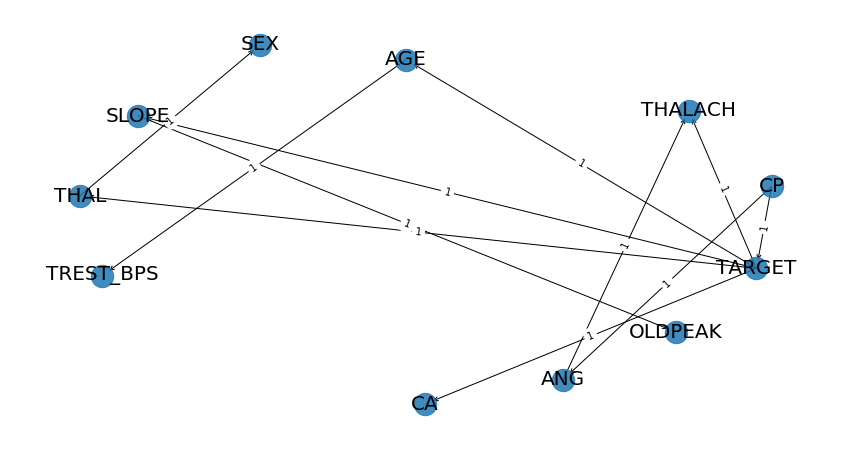

Wall time: 18.3 s


In [167]:
%%time
hcs = HillClimbSearch(p.data, scoring_method=BicScore(p.data))
best_model = hcs.estimate(max_indegree=2) # max_indegree=2

print(f"Best nodes: \n {sorted(best_model.nodes())} \n")
print(f"Best edges: \n {best_model.edges()} \n")

G = bnlearn.plot(best_model)

In [119]:
best_model.graph


{}

In [176]:
best_model.edges()

OutEdgeView([('AGE', 'TREST_BPS'), ('CP', 'TARGET'), ('CP', 'ANG'), ('ANG', 'THALACH'), ('SLOPE', 'OLDPEAK'), ('THAL', 'SEX'), ('TARGET', 'THAL'), ('TARGET', 'CA'), ('TARGET', 'THALACH'), ('TARGET', 'SLOPE'), ('TARGET', 'AGE')])

In [177]:
from pgmpy.models import BayesianModel

s = BayesianModel()
# s.check_model()
s.add_nodes_from(best_model.nodes())
s.add_edges_from(best_model.edges())
s.fit(p.data)
s.get_cpds()[0].__dict__


{'variable': 'AGE',
 'variable_card': 4,
 'variables': ['AGE', 'TARGET'],
 'cardinality': array([4, 2]),
 'values': array([[0.17391304, 0.35365854],
        [0.18115942, 0.26829268],
        [0.37681159, 0.17073171],
        [0.26811594, 0.20731707]]),
 'state_names': {'AGE': [Interval(28.999, 48.0, closed='right'),
   Interval(48.0, 55.5, closed='right'),
   Interval(55.5, 61.0, closed='right'),
   Interval(61.0, 77.0, closed='right')],
  'TARGET': [0, 1]},
 'name_to_no': {'AGE': {Interval(28.999, 48.0, closed='right'): 0,
   Interval(48.0, 55.5, closed='right'): 1,
   Interval(55.5, 61.0, closed='right'): 2,
   Interval(61.0, 77.0, closed='right'): 3},
  'TARGET': {0: 0, 1: 1}},
 'no_to_name': {'AGE': {0: Interval(28.999, 48.0, closed='right'),
   1: Interval(48.0, 55.5, closed='right'),
   2: Interval(55.5, 61.0, closed='right'),
   3: Interval(61.0, 77.0, closed='right')},
  'TARGET': {0: 0, 1: 1}}}

In [171]:
from pgmpy.factors.discrete import JointProbabilityDistribution

In [172]:
s.marginal_distribution()

AttributeError: 'BayesianModel' object has no attribute 'marginal_distribution'

In [173]:
s.__dict__

{'graph_attr_dict_factory': dict,
 'node_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'adjlist_inner_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 '_node': {'AGE': {'weight': None},
  'SEX': {'weight': None},
  'CP': {'weight': None},
  'TREST_BPS': {'weight': None},
  'CHOL': {'weight': None},
  'FBS': {'weight': None},
  'REST_ECG': {'weight': None},
  'THALACH': {'weight': None},
  'ANG': {'weight': None},
  'OLDPEAK': {'weight': None},
  'SLOPE': {'weight': None},
  'CA': {'weight': None},
  'THAL': {'weight': None},
  'TARGET': {'weight': None}},
 '_adj': {'AGE': {'TREST_BPS': {'weight': None}},
  'SEX': {},
  'CP': {'TARGET': {'weight': None}, 'ANG': {'weight': None}},
  'TREST_BPS': {},
  'CHOL': {},
  'FBS': {},
  'REST_ECG': {},
  'THALACH': {},
  'ANG': {'THALACH': {'weight': None}},
  'OLDPEAK': {},
  'SLOPE': {'OLDPEAK': {'weight': None}},
  'CA': {},
  'THAL': {'SEX': {'weight': None}},
  'TARGET': {'THA